# Experiment with Bezier curve fitting

This is a Python prototype that might be sufficient. If not, I will port it to C++ and create Python bindings (which I really want to do!).

First, I will experiment w the IAM OnDB Dataset (untransformed sample) and then later with an example obtained from Xournal++.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

from src.data.online_handwriting_datasets import IAM_OnDB_Dataset

## Helper functions

These functions are experiments for now and will eventually be moved into the `src/` module.

In [ ]:
# TODO

## Load example data

Example data here refers to a single sample that I can experiment with to fit to Bezier curves.

In [8]:
PATH = Path('../data/datasets/IAM-OnDB') # Needs to be parameterised

ds = IAM_OnDB_Dataset(path=PATH, transform=None, limit=100)

Load data for IAM_OnDB_Dataset: 0it [00:00, ?it/s]

Load data for IAM_OnDB_Dataset: 19it [00:01, 15.73it/s]


Select a particular sample to focus on now:

In [16]:
i_selected = 0

sample = ds[i_selected]

Plot the sample:

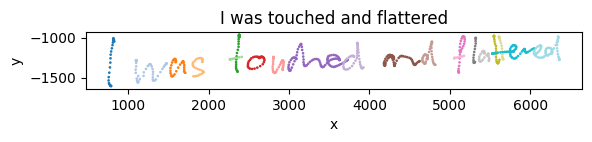

In [25]:
import matplotlib.pyplot as plt


plt.figure()
plt.scatter(sample['x'], sample['y'], c=sample['stroke_nr'], s=0.8, cmap='tab20')
plt.title(sample['label'])
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.show()

## Optimise data structure for better experimentation

First, I load the sample into `pandas`. Then, I groupby the sample w.r.t. `stroke_nr` and store the result in a simple list for now.

In [35]:
import pandas as pd

df = pd.DataFrame.from_dict({
    'x': sample['x'],
    'y': sample['y'],
    't': sample['t'],
    'stroke_nr': sample['stroke_nr'],
})

list_of_strokes = []

for stroke_nr, df_grouped in df.groupby('stroke_nr'):
    list_of_strokes.append({
        'x': sample['x'],
        'y': sample['y'],
        't': sample['t'],
    })

## Understand [Carbune2020] fitting procedure

TODO Continue here next!